# Расчетная работа по курсу: Теория вероятности и статистика

## 1 Раздел

### Импортируем все необходимые библиотеки

Здесь:
- Numpy и его подмодули:
    - `numpy` - общий модуль для работы с тензорами и статистических вычислений

- SciPy и его подмодули
    - `stats` - для получения функции плотности вероятности из модуля `norm`
    - `optimize` - для получения функции минимизации
    - `integrate` - для подсчета интеграла

- MatPlotLib и Seaborn:
    - `matplotlib.pyplot` или `plt` - для графиков
    - `seaborn` - для красивых графиков

In [1]:
import numpy as np

from scipy import stats
from scipy import optimize
import scipy.integrate as integrate

import matplotlib.pyplot as plt
import seaborn as sns

import re

### Вводим константы по варианту и seed для повторяемости результатов

In [2]:
n = 500             # Размер выборки
MX = 3.9            # Мат. ожидание (mean) - средняя
DX = 4.3            # Дисперсия
SIGMA = np.sqrt(DX) # Корень от дисперсии это ср. квадратичное отклонение
GAMMA = 0.9         # Доверительная вероятность
ALPHA = 0.025       # Уровень значимости

SEED = 228          # Для повторения результатов

### 1.0 Функция нормального (Гауссовского) распределения случайной величины
$$p(x)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(x-a)^{2}}{2\sigma^{2}}}$$

Для выборки воспльзуемся `scipy`

In [3]:
x: np.ndarray = stats.norm.rvs(loc=MX, scale=SIGMA, size=n, random_state=SEED)
print(f"Первые 6 значений вектора:\n{re.sub(" +", ", ", str(x[:6])[2:-1])}...")
print(f"Размерность выборки: {str(x.shape)[1:-2]}")

Первые 6 значений вектора:
6.53625429, -0.91170967, 1.67480578, 6.62595839, 8.13722897, 0.99881286...
Размерность выборки: 500


In [4]:
x = np.random.random(500)

### 1.1 Гистограмма полученного вектора выборки и теоретической
Получанный вектор:

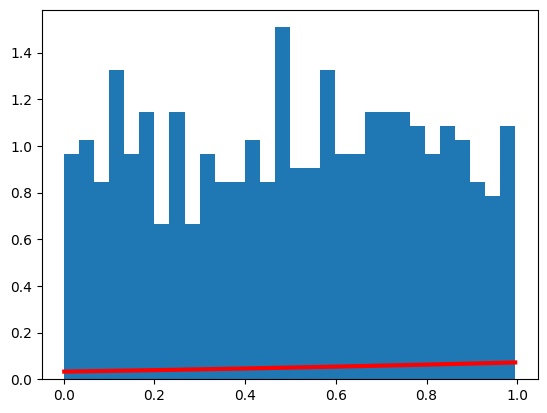

In [5]:
_, theoretic_x, _ = plt.hist(x, 30, density=True)

theoretic_normal_distribution = 1 / \
    (SIGMA * np.sqrt(2 * np.pi)) * \
    np.exp(- (theoretic_x - MX)**2 / (2 * SIGMA**2))

plt.plot(theoretic_x, theoretic_normal_distribution, linewidth=3, color='r')
plt.show()

### 1.2 Выборчная средняя и дисперсия

Формула для выборочной средней:

$$\bar{X} = \frac{1}{n}\sum_{i=0}^{n-1}x_{i}$$

Формула для выборочной дисперсии:

$$S^2 = \frac{1}{n}\sum_{i=0}^{n-1}(x_{i}-\bar{x})^2$$

In [6]:
sample_average = x.sum() / n

sum_tmp = 0

for i in range(n):
    sum_tmp += (x[i] - sample_average) ** 2

sample_variance = sum_tmp / n

print(f"Выборочная средняя: {sample_average}\nВыборочная дисперсия: {sample_variance}")

Выборочная средняя: 0.5027613767659362
Выборочная дисперсия: 0.08140594754477773


### 1.3 Получить оценки мат. ожидания и дисперсии методом максимального правдоподобия
#### Оценки

In [7]:
def likelihood(params, x):
    return stats.norm.logpdf(x, loc=params[0], scale=params[1]).sum()

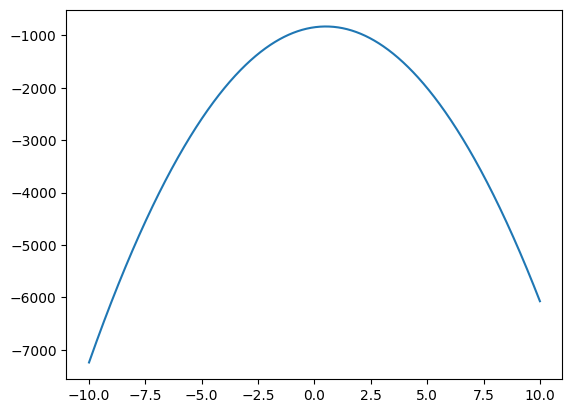

In [8]:
plt.plot(np.linspace(-10, 10, 1000), [likelihood([val, SIGMA], x) for val in np.linspace(-10, 10, 1000)])
plt.show()

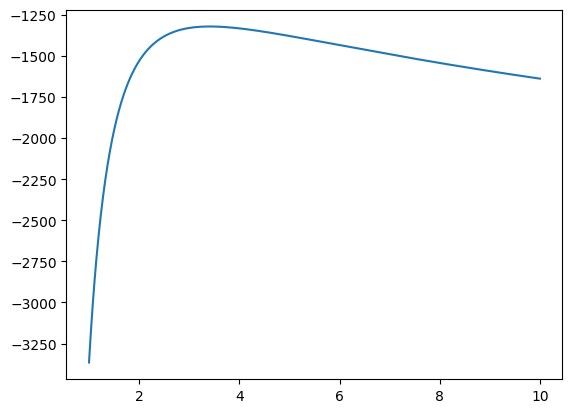

In [9]:
plt.plot(np.linspace(1, 10, 1000), [likelihood([MX, val], x) for val in np.linspace(1, 10, 1000)])
plt.show()

In [10]:
def neglikelihood_MX(MX):
    return -1 * likelihood([MX, SIGMA], x)

def neglikelihood_SIGMA(SIGMA):
    return -1 * likelihood([MX, SIGMA], x)

In [11]:
estimator_MX = optimize.minimize(neglikelihood_MX, 10)
estimator_SIGMA = optimize.minimize(neglikelihood_SIGMA, 10)
print(f"Оценка мат. ожидания: {str(estimator_MX.x)[1:-1]}\nОценка дисперсии: {str(estimator_SIGMA.x ** 2)[1:-1]}")

Оценка мат. ожидания: 0.50276136
Оценка дисперсии: 1.21465651e+08


#### Несмещнная оценка дисперсии
$$S'^{2}=\frac{1}{n-1}\sum^{n}_{i=1}(X_i-\bar{X})^2=\frac{n}{n-1}S^2$$

Тогда несмещенную оценку посчитаем используя выборочную дисперсию $S^2$

In [12]:
unbiased_variance = (n * sample_variance) / (n - 1)
print(f"Несмещенная оценка дисперсии: {unbiased_variance}")

Несмещенная оценка дисперсии: 0.08156908571621015


### 1.4 Построить доверительные интервалы для MX и DX, соответсвующие $\gamma$

#### Формулы:

Формула для нахождения интервальной оценки MX, при известном DX: 
$$\Delta_{\gamma}(\theta)=(\bar{X}-c_{(1+\gamma)/2}\frac{\sigma}{\sqrt{n}},\bar{X}+c_{(1+\gamma)/2}\frac{\sigma}{\sqrt{n}})$$

где $\bar{X}$ - выборочное среднее<br/>*n* - размер выборки<br/>$c_{(1+\gamma)/2}$ - такое значение функции Лапласа $Ф(x)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{x}e^{-u^2/2}du$, при котором $Ф(c_{(1+\gamma)/2})=(1+\gamma)/2$<br/>$c_{(1+\gamma)/2}$ находят по таблице Б.2

Формула для нахождения интервальной оценки DX, при известном MX:
$$\Delta_{\gamma}(\theta^2)=\Big(\frac{\sum_{i=1}^{n}(X_i-a)^2}{\chi^2_{(1+\gamma)/2;n}};\frac{\sum_{i=1}^{n}(X_i-a)^2}{\chi^2_{(1-\gamma)/2;n}}\Big)$$

где $\chi^2_{(1+\gamma)/2;n}$ это $(1+\gamma)/2$ квантили распределения $\chi^2(n)$ с *n* степенями свободы<br/>
Искать в таблице Г.2

#### Найдем интервальную оценку MX
Получим $c_{(1+\gamma)/2}$ используя таблицу, при $\gamma=0.9$.<br/><br/>
Решим уравнение:
$$Ф(c_{(1+\gamma)/2})=(1+\gamma)/2$$
$$Ф(c_{(1+\gamma)/2})=0.95$$
Тогда $c_{(1+\gamma)/2}=1.645$

In [13]:
interval_MX = sample_average - 1.645 * (SIGMA / np.sqrt(n)), sample_average + 1.645 * (SIGMA / np.sqrt(n))

print(f"Интервальная оценка MX: {interval_MX}")

Интервальная оценка MX: (0.35021035251503196, 0.6553124010168405)


#### Найдем интервальную оценку DX
Так как $n\ge30$ ($n=500$), то воспользуемся формулой: $$\chi^2_{\gamma,n}\approx\frac{(c_p+\sqrt{2n-1})^2}{2}$$
где $c_p$ квантиль нормального распределения из таблицы Б.2 <br/>
Возьмем значения из таблицы: 
$$c_p=1.645 \quad \text{(при} \> p=(1+\gamma)/2=0.95\text{)}$$
$$c_p=-1.645 \quad \text{(при} \> p=(1-\gamma)/2=0.05\text{)}$$
<br/>Тогда:
$$\chi^2_{(1+\gamma)/2;n}\approx552.84646$$
$$\chi^2_{(1-\gamma)/2;n}\approx448.85956$$

In [14]:
sum_tmp = 0

for i in range(n):
    sum_tmp += (x[i] - MX) ** 2

interval_DX = sum_tmp / 552.84646, sum_tmp / 448.85956

print(f"Интервальная оценка DX: {interval_DX}")

Интервальная оценка DX: (10.511631213789501, 12.946851583976576)


### 1.5 Проверка статестической гипотизы

#### 1. По заданной $\alpha=0.025$ найдем порог для $\chi^2_{1-\alpha;N-1}$ по таблице Г.1 
$$1-\alpha=1-0.025=p=0.975$$
$$N-1=n=499$$

При $n\ge30$ используется формула $$\chi^2_{p,n}\approx\frac{(c_p+\sqrt{2n-1})^2}{2}$$
где $c_p$ искать в таблице Б.2

$$c_p=1.960 \quad \text{(при} \> p=0.975\text{)}$$
Тогда $$\chi^2_{0.975,499}\approx\frac{(1.960+\sqrt{2\times499-1})^2}{2}\approx1.98319\times10^6$$

#### 2. Группировка по интервальным статистическим рядам и вычисление значение статистики

##### 2.1 Группировка
2.1.1 Построим вариационный ряд (упорядоченную выборку), то есть $x_1\le x_2\le ...\le x_n$

In [15]:
variation_series = x.copy()
variation_series.sort()
print(f"Вариационный ряд: {re.sub(" +", ", ", str(variation_series[:6])[1:-1])}...")

Вариационный ряд: 0.00114938, 0.00120948, 0.00213995, 0.00533683, 0.01134258, 0.01193426...


2.1.2 Разбиваем на непересекающиеся интервалы
<br/>Найдем мин. и макс. значение в ряде

In [16]:
print(f"Минимальное: {min(variation_series)}")
print(f"Максимальное: {max(variation_series)}")

Минимальное: 0.0011493777069704336
Максимальное: 0.995418151455891


Кол-во интервалов, *N*: 8

In [17]:
N = 8

Считаем длины интервалов: $$h=\frac{x_{max}-x_{min}}{k}$$

In [18]:
h = (max(variation_series) - min(variation_series)) / N
print(f"Длина интервала: {h}")

Длина интервала: 0.12428359671861507


Получаем такие интервалы:

In [19]:
intervals = [[min(variation_series) + k * h, min(variation_series) + (k + 1) * h] for k in range(N)]

for (n, interval) in enumerate(intervals):
    print(f"Интервал {n}: {str(interval)[:-1]})")

Интервал 0: [0.0011493777069704336, 0.1254329744255855)
Интервал 1: [0.1254329744255855, 0.24971657114420057)
Интервал 2: [0.24971657114420057, 0.37400016786281565)
Интервал 3: [0.37400016786281565, 0.4982837645814307)
Интервал 4: [0.4982837645814307, 0.6225673613000458)
Интервал 5: [0.6225673613000458, 0.7468509580186609)
Интервал 6: [0.7468509580186609, 0.8711345547372759)
Интервал 7: [0.8711345547372759, 0.995418151455891)


Разбиваем на интервалы

In [20]:
J = [[] for _ in range(len(intervals))]

for xi in variation_series:
    for i in range(len(intervals)):
        if (intervals[i][0] <= xi < intervals[i][1]):
            J[i].append(xi)
J[-1].append(max(variation_series))


total_length = 0
for interval in J:
    total_length += len(interval)
print(f"Суммарная длина интервалов: {total_length}")

Суммарная длина интервалов: 500


2.1.3 Теперь подсчитаем частоты

In [21]:
frequencies = []

for interval in J:
    frequencies.append(len(interval))

print(f"Частоты попадания выборочных значений: {frequencies}")

Частоты попадания выборочных значений: [60, 66, 51, 68, 63, 68, 66, 58]


2.1.4 Проверяем гипотезу

Считаем по формуле: $$\chi^2_n=\sum^N_{k=1}\frac{(\nu_k-n p_k)^2}{n p_k}$$
Где $p_k$ считается по формуле: $$p_k = F(u_k)-F(u_{k-1})$$
Где $$F(x)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{x}e^{-t^2/2}dt$$
Напишем функцию $F(x)$

In [22]:
def F(x):
    # res = 1 / (2 * np.pi)
    res = integrate.quad(lambda t: np.exp(-t**2 / 2), -np.inf, x)[0]
    return res

In [23]:
p = [F(val[-1]) - F(val[0]) for val in J]

In [24]:
chi = 0
for k in range(N):
    chi += (frequencies[k] - n * p[k])**2 / n * p[k]
print(f"Критерий Пирсона: {chi}")

Критерий Пирсона: 454.31270820492705
